In [ ]:
pip install geopandas

### 1. Connecter sur le Drive pour récupérer les fichiers si Google Coolab

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Rbnb"

### Contexte

#### L'objectif est de réduire les logements Airbnb disponibles sur Paris, à partir de certains paramètres.

    la date de début de séjour
    le nombre de personnes logées
    le tarif journalier max
    la qualité de l'hôte (paramètre 'superhost')

#### Typologies d'usage

    Un couple avec 2 enfants cherche un logement pour un week end à Paris.
    Ou un propriétaire cherche à faire un benchmark sur les tarifs pratiqués sur le logement qu'il souhaite mettre en location.

#### Superhost requirements

    Completed at least 10 trips OR successfully completed 3 reservations that total at least 100 nights
    Maintained a 90% response rate or higher
    Maintained a 1% percent cancellation rate (1 cancellation per 100 reservations) or lower, with exceptions made for those that fall under our Extenuating Circumstances policy
    Maintain a 4.8 overall rating



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import datetime

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#to make the interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

### Saisir les paramètres

In [28]:
# saisir la date souhaitée
print('Date souhaitée (aaaa-mm-jj) : ')
wdate = input()

import datetime

d_s = datetime.datetime.strptime(wdate,"%Y-%m-%d").strftime('%Y-%m-%d')

Date souhaitée (aaaa-mm-jj) : 
2019-08-24


In [29]:
# saisir les critères de recherche : nombre de personnes
print('Nombre de personnes : ')
n_p = int(input())

Nombre de personnes : 
4


In [30]:
# saisir les critères de recherche : tarif journalier max
print('Prix max / jour : ')
p_m = int(input())

Prix max / jour : 
50


### Réduire le set de données avec les paramètres saisis

#### Calendar

    Date choisie
    Disponibilité du logement


In [31]:
calendar = pd.read_csv("/Users/Johanna/Documents/SIMPLON/PROJET/09. Airbnb Paris Aout 2019/source/calendar.csv")

In [32]:
# chaque logement répertorié dans le fichier Airbnb génère 365 lignes (soit 1 ligne par jour) dans le fichier calendar
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23467355 entries, 0 to 23467354
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    float64
maximum_nights    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ GB


In [33]:
# convertir la colonne date sous le format date
calendar['date'] = pd.to_datetime(calendar['date'])

In [34]:
calendar.available = calendar.available.replace({"t": "True", "f": "False"})

In [35]:
# filtrer sur la date saisie 
fd = (calendar.date == d_s) # créer le filtre
calendar_d = calendar[fd] # l'appliquer sur le df calendar pour ne retenir que les lignes avec la date concernée
calendar_d.listing_id.count() # vérifier que le filtre a fonctionné

64293

In [36]:
# filtrer sur les logements disponibles 
fa = (calendar_d.available == "True")
calendar_a = calendar_d[fa] # l'appliquer au df précédent
calendar_a.listing_id.count() # nombre de logements disponibles à la date concernée

18530

In [37]:
# mettre adjusted_price au format chiffre
calendar_a.adjusted_price = calendar_a.adjusted_price.str.replace('$', '')
calendar_a.adjusted_price = calendar_a.adjusted_price.str.replace(',', '')
calendar_a.adjusted_price = pd.to_numeric(calendar_a.adjusted_price) 

/Applications/anaconda3/envs/Airbnb/lib/python3.7/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [38]:
# vérifier le résultats suite aux applications des filtres 
calendar_a.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
45,3109,2019-08-24,True,$60.00,60.0,3.0,15.0
2234,9952,2019-08-24,True,$100.00,100.0,5.0,120.0
4060,11213,2019-08-24,True,$157.00,157.0,1.0,730.0
4425,11265,2019-08-24,True,$99.00,99.0,7.0,90.0
4790,11798,2019-08-24,True,$120.00,120.0,2.0,20.0


Double-cliquez (ou appuyez sur Entrée) pour modifier

### Réduire le set de données avec les paramètres saisis

#### Listings et listings_details

In [39]:
listings = pd.read_csv("/Users/Johanna/Documents/SIMPLON/PROJET/09. Airbnb Paris Aout 2019/source/listings.csv", index_col= "id")

In [40]:
# examiner la structure du fichier et la typologie des colonnes
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64293 entries, 3109 to 36561242
Data columns (total 15 columns):
name                              64224 non-null object
host_id                           64293 non-null int64
host_name                         64229 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     64293 non-null object
latitude                          64293 non-null float64
longitude                         64293 non-null float64
room_type                         64293 non-null object
price                             64293 non-null int64
minimum_nights                    64293 non-null int64
number_of_reviews                 64293 non-null int64
last_review                       49684 non-null object
reviews_per_month                 49684 non-null float64
calculated_host_listings_count    64293 non-null int64
availability_365                  64293 non-null int64
dtypes: float64(4), int64(6), object(5)
memory usag

In [41]:
# retenir certaines colonnes du fichier listings
ltarget_columns = ["host_id", "neighbourhood", "latitude", "longitude"]
listing_sl = listings[ltarget_columns]
listing_sl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64293 entries, 3109 to 36561242
Data columns (total 4 columns):
host_id          64293 non-null int64
neighbourhood    64293 non-null object
latitude         64293 non-null float64
longitude        64293 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.5+ MB


In [42]:
# préparer listing_sl pour la jointure avec calendar
listing_sl.index.name = "listing_id"

In [43]:
listing_sl.head()

,host_id,neighbourhood,latitude,longitude
listing_id,,,,
3109,3631,Observatoire,48.83349,2.31852
5396,7903,Hôtel-de-Ville,48.85100,2.35869
7397,2626,Hôtel-de-Ville,48.85758,2.35275
7964,22155,Opéra,48.87464,2.34341
8522,25435,Ménilmontant,48.86528,2.39326


In [44]:
# jointure calendar et listings 
clj = pd.merge(calendar_a, listing_sl, on = 'listing_id', how = 'left')

In [45]:
clj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18530 entries, 0 to 18529
Data columns (total 11 columns):
listing_id        18530 non-null int64
date              18530 non-null datetime64[ns]
available         18530 non-null object
price             18530 non-null object
adjusted_price    18530 non-null float64
minimum_nights    18530 non-null float64
maximum_nights    18530 non-null float64
host_id           18530 non-null int64
neighbourhood     18530 non-null object
latitude          18530 non-null float64
longitude         18530 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 1.7+ MB


In [46]:
clj.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,host_id,neighbourhood,latitude,longitude
0,3109,2019-08-24,True,$60.00,60.0,3.0,15.0,3631,Observatoire,48.83349,2.31852
1,9952,2019-08-24,True,$100.00,100.0,5.0,120.0,33534,Popincourt,48.86227,2.37134
2,11213,2019-08-24,True,$157.00,157.0,1.0,730.0,41322,Entrepôt,48.87110,2.37424
3,11265,2019-08-24,True,$99.00,99.0,7.0,90.0,41718,Buttes-Montmartre,48.88434,2.34005
4,11798,2019-08-24,True,$120.00,120.0,2.0,20.0,44444,Gobelins,48.82405,2.36828


In [47]:
listings_details = pd.read_csv("/Users/Johanna/Documents/SIMPLON/PROJET/09. Airbnb Paris Aout 2019/source/listings_details.csv", index_col= "id", low_memory=False)

In [48]:
# préparer listing_details pour la jointure avec clj
listings_details.index.name = "listing_id"

In [49]:
listings_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64293 entries, 3109 to 36561242
Columns: 105 entries, listing_url to reviews_per_month
dtypes: float64(23), int64(20), object(62)
memory usage: 52.0+ MB


In [50]:
# retenir certaines colonnes du fichier listings_details et joindre les 2 listes
dtarget_columns = ["neighbourhood_cleansed", "accommodates", "host_is_superhost"]
cljv2 = pd.merge(clj, listings_details[dtarget_columns], on='listing_id', how='left')
cljv2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18530 entries, 0 to 18529
Data columns (total 14 columns):
listing_id                18530 non-null int64
date                      18530 non-null datetime64[ns]
available                 18530 non-null object
price                     18530 non-null object
adjusted_price            18530 non-null float64
minimum_nights            18530 non-null float64
maximum_nights            18530 non-null float64
host_id                   18530 non-null int64
neighbourhood             18530 non-null object
latitude                  18530 non-null float64
longitude                 18530 non-null float64
neighbourhood_cleansed    18530 non-null object
accommodates              18530 non-null int64
host_is_superhost         18509 non-null object
dtypes: datetime64[ns](1), float64(5), int64(3), object(5)
memory usage: 2.1+ MB


In [51]:
cljv2.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,host_id,neighbourhood,latitude,longitude,neighbourhood_cleansed,accommodates,host_is_superhost
0,3109,2019-08-24,True,$60.00,60.0,3.0,15.0,3631,Observatoire,48.83349,2.31852,Observatoire,2,f
1,9952,2019-08-24,True,$100.00,100.0,5.0,120.0,33534,Popincourt,48.86227,2.37134,Popincourt,2,f
2,11213,2019-08-24,True,$157.00,157.0,1.0,730.0,41322,Entrepôt,48.87110,2.37424,Entrepôt,6,f
3,11265,2019-08-24,True,$99.00,99.0,7.0,90.0,41718,Buttes-Montmartre,48.88434,2.34005,Buttes-Montmartre,2,f
4,11798,2019-08-24,True,$120.00,120.0,2.0,20.0,44444,Gobelins,48.82405,2.36828,Gobelins,3,t


In [52]:
cljv2.host_is_superhost = cljv2.host_is_superhost.replace({"t": "True", "f": "False"})

In [53]:
# filtrer sur le nombre de personnes
fnp = (cljv2.accommodates >= n_p)
cldm_np = cljv2[fnp]
cldm_np.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7638 entries, 2 to 18529
Data columns (total 14 columns):
listing_id                7638 non-null int64
date                      7638 non-null datetime64[ns]
available                 7638 non-null object
price                     7638 non-null object
adjusted_price            7638 non-null float64
minimum_nights            7638 non-null float64
maximum_nights            7638 non-null float64
host_id                   7638 non-null int64
neighbourhood             7638 non-null object
latitude                  7638 non-null float64
longitude                 7638 non-null float64
neighbourhood_cleansed    7638 non-null object
accommodates              7638 non-null int64
host_is_superhost         7628 non-null object
dtypes: datetime64[ns](1), float64(5), int64(3), object(5)
memory usage: 895.1+ KB


In [54]:
# vérifier le résultat du filtre
cldm_np.head(5)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,host_id,neighbourhood,latitude,longitude,neighbourhood_cleansed,accommodates,host_is_superhost
2,11213,2019-08-24,True,$157.00,157.0,1.0,730.0,41322,Entrepôt,48.87110,2.37424,Entrepôt,6,False
7,59959,2019-08-24,True,$130.00,130.0,3.0,31.0,288512,Buttes-Chaumont,48.89368,2.38419,Buttes-Chaumont,4,False
8,60165,2019-08-24,True,$70.00,70.0,3.0,20.0,289696,Buttes-Montmartre,48.88741,2.34924,Buttes-Montmartre,4,False
9,21004,2019-08-24,True,$190.00,190.0,2.0,40.0,79843,Reuilly,48.84000,2.40067,Reuilly,5,False
11,16455,2019-08-24,True,$90.00,90.0,7.0,730.0,64054,Gobelins,48.83616,2.36323,Gobelins,5,False


In [55]:
# filtrer sur le prix max
fpm = (cldm_np.adjusted_price <= p_m)
cldm_pm = cldm_np[fpm]
cldm_pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 25 to 18495
Data columns (total 14 columns):
listing_id                93 non-null int64
date                      93 non-null datetime64[ns]
available                 93 non-null object
price                     93 non-null object
adjusted_price            93 non-null float64
minimum_nights            93 non-null float64
maximum_nights            93 non-null float64
host_id                   93 non-null int64
neighbourhood             93 non-null object
latitude                  93 non-null float64
longitude                 93 non-null float64
neighbourhood_cleansed    93 non-null object
accommodates              93 non-null int64
host_is_superhost         93 non-null object
dtypes: datetime64[ns](1), float64(5), int64(3), object(5)
memory usage: 10.9+ KB


In [56]:
# vérifier le résultat du filtre
cldm_pm.head(5)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,host_id,neighbourhood,latitude,longitude,neighbourhood_cleansed,accommodates,host_is_superhost
25,150800,2019-08-24,True,$40.00,40.0,1.0,365.0,726311,Buttes-Chaumont,48.87439,2.38476,Buttes-Chaumont,6,False
32,154984,2019-08-24,True,$40.00,40.0,1.0,365.0,726311,Buttes-Chaumont,48.87442,2.38340,Buttes-Chaumont,6,False
33,155072,2019-08-24,True,$40.00,40.0,1.0,365.0,726311,Buttes-Chaumont,48.87460,2.38487,Buttes-Chaumont,6,False
46,163384,2019-08-24,True,$40.00,40.0,1.0,730.0,726311,Buttes-Chaumont,48.87497,2.38483,Buttes-Chaumont,6,False
89,142507,2019-08-24,True,$50.00,50.0,1.0,730.0,596692,Gobelins,48.82521,2.35752,Gobelins,4,False


In [57]:
# filtrer sur les superhost
fsh = (cldm_pm.host_is_superhost == "True") 
paris = cldm_pm[fsh] # l'appliquer au df précédent
paris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 1032 to 17032
Data columns (total 14 columns):
listing_id                4 non-null int64
date                      4 non-null datetime64[ns]
available                 4 non-null object
price                     4 non-null object
adjusted_price            4 non-null float64
minimum_nights            4 non-null float64
maximum_nights            4 non-null float64
host_id                   4 non-null int64
neighbourhood             4 non-null object
latitude                  4 non-null float64
longitude                 4 non-null float64
neighbourhood_cleansed    4 non-null object
accommodates              4 non-null int64
host_is_superhost         4 non-null object
dtypes: datetime64[ns](1), float64(5), int64(3), object(5)
memory usage: 480.0+ bytes


In [58]:
# vérifier le résultat du filtre
paris.head(5)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,host_id,neighbourhood,latitude,longitude,neighbourhood_cleansed,accommodates,host_is_superhost
1032,1548562,2019-08-24,True,$45.00,45.0,2.0,25.0,7974408,Ménilmontant,48.85471,2.40951,Ménilmontant,4,True
1725,3335021,2019-08-24,True,$49.00,49.0,10.0,120.0,3497395,Ménilmontant,48.86954,2.39148,Ménilmontant,4,True
6661,19857887,2019-08-24,True,$40.00,40.0,10.0,1125.0,14070690,Buttes-Chaumont,48.88558,2.38359,Buttes-Chaumont,4,True
17032,36019354,2019-08-24,True,$50.00,50.0,30.0,1125.0,6069249,Temple,48.86245,2.35830,Temple,4,True


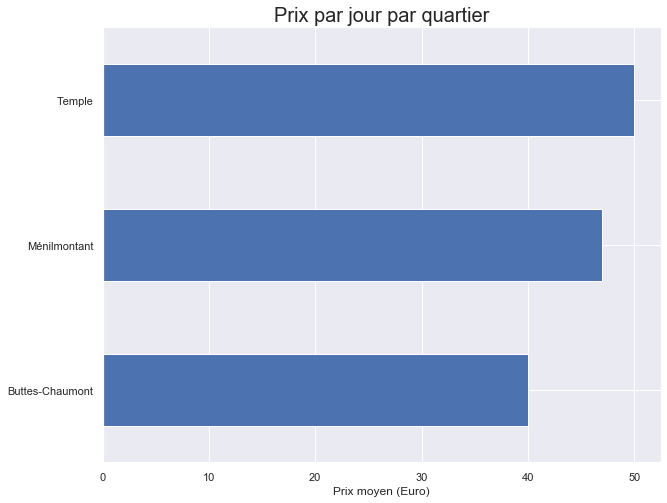

In [59]:
feq = paris[paris['accommodates']== n_p] 
feq = feq.groupby('neighbourhood')['adjusted_price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=0.5)
plt.title("Prix par jour par quartier", fontsize=20)
plt.xlabel('Prix moyen (Euro)', fontsize=12)
plt.ylabel("")
plt.show()

In [60]:
lats2019 = paris['latitude'].tolist()
lons2019 = paris['longitude'].tolist()
locations = list(zip(lats2019, lons2019))

map1 = folium.Map(location=[48.8534, 2.3488], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

# map1.save("map1.html")